# Pima Diabetes — Pipelines, Voting & Stacking (5‑Fold CV)

**What this notebook does**

- Performs class-conditional median imputation for physiologically implausible zeros.
- Builds consistent `Pipeline`s for multiple classifiers.
- Evaluates models using **Stratified 5‑Fold Cross‑Validation** and reports mean ± std for Accuracy, Precision, Recall, F1, ROC‑AUC.
- Creates **Soft Voting** and **Stacking** ensembles using all models and the top 3–4 models.
- Plots ROC curves on a held-out test set for visualization.
- Optionally runs SHAP explainability for the best performing model.

---


In [1]:
# Setup: install packages if missing (uncomment pip lines if needed)
import sys, subprocess

def pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

required = ["pandas","numpy","scikit-learn","xgboost","lightgbm","matplotlib","seaborn","joblib", "shap", "imblearn"]
print("Setup cell ready. If you don't have required packages, uncomment the pip install block and run this cell.")
# Example to install:
for p in required:
      pip_install(p)


Setup cell ready. If you don't have required packages, uncomment the pip install block and run this cell.


In [2]:
# Load dataset and show basic info
import pandas as pd
df = pd.read_csv("diabetes.csv")
print("Shape:", df.shape)
display(df.head(10))
print("\nClass distribution:\n", df["Outcome"].value_counts())


Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1



Class distribution:
 Outcome
0    500
1    268
Name: count, dtype: int64


In [3]:
# Preprocessing: treat zeros as missing for selected features and do class-conditional median imputation
import numpy as np

df_proc = df.copy()
zero_as_missing = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]

for col in zero_as_missing:
    df_proc.loc[df_proc[col] == 0, col] = np.nan

# compute medians per class and impute
medians = {}
for col in zero_as_missing:
    medians[col] = {}
    medians[col][0] = df_proc.loc[df_proc["Outcome"]==0, col].median()
    medians[col][1] = df_proc.loc[df_proc["Outcome"]==1, col].median()
    df_proc.loc[df_proc["Outcome"]==0, col] = df_proc.loc[df_proc["Outcome"]==0, col].fillna(medians[col][0])
    df_proc.loc[df_proc["Outcome"]==1, col] = df_proc.loc[df_proc["Outcome"]==1, col].fillna(medians[col][1])

print("Imputation medians used:")
for col in zero_as_missing:
    print(f" {col}: non-diabetic median={medians[col][0]:.3f}, diabetic median={medians[col][1]:.3f}")

# quick stats
display(df_proc.describe().round(3))


Imputation medians used:
 Glucose: non-diabetic median=107.000, diabetic median=140.000
 BloodPressure: non-diabetic median=70.000, diabetic median=74.500
 SkinThickness: non-diabetic median=27.000, diabetic median=32.000
 Insulin: non-diabetic median=102.500, diabetic median=169.500
 BMI: non-diabetic median=30.100, diabetic median=34.300


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,121.677,72.389,29.090,141.754,32.435,0.472,33.241,0.349
std,3.370,30.464,12.106,8.891,89.101,6.880,0.331,11.760,0.477
min,0.000,44.000,24.000,7.000,14.000,18.200,0.078,21.000,0.000
25%,1.000,99.750,64.000,25.000,102.500,27.500,0.244,24.000,0.000
50%,3.000,117.000,72.000,28.000,102.500,32.050,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,169.500,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


In [4]:
#function to add a new feature of BMI/Age
def BMI_AGE(df):
    df['BMI_Age'] = df['BMI']/df['Age']
    return df

#function to change diabetes pedigree function into true or false, true if >= 0.471876, for easier understanding
def diabeticfamily(value):
    if value >= 0.471876:
        return 1
    else:
        return 0

df_proc['familydiabetic'] = df_proc['DiabetesPedigreeFunction'].map(diabeticfamily)
df_proc = BMI_AGE(df_proc)
df_proc = df_proc[['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'familydiabetic', 'Age', 'BMI_Age', 'Outcome']]

display(df_proc.describe().round(3))

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,familydiabetic,Age,BMI_Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,121.677,72.389,141.754,32.435,0.384,33.241,1.076,0.349
std,3.370,30.464,12.106,89.101,6.880,0.487,11.760,0.377,0.477
min,0.000,44.000,24.000,14.000,18.200,0.000,21.000,0.272,0.000
25%,1.000,99.750,64.000,102.500,27.500,0.000,24.000,0.805,0.000
50%,3.000,117.000,72.000,102.500,32.050,0.000,29.000,1.040,0.000
75%,6.000,140.250,80.000,169.500,36.600,1.000,41.000,1.318,1.000
max,17.000,199.000,122.000,846.000,67.100,1.000,81.000,2.605,1.000


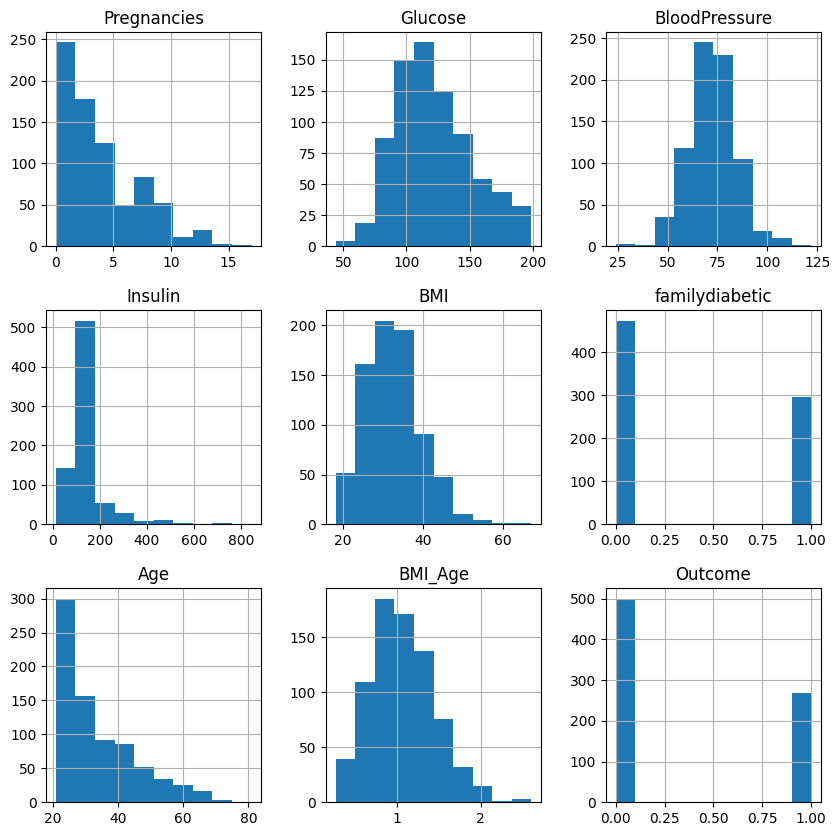

In [5]:
#Showing histogram of the df
histogram = df_proc.hist(bins=10,figsize=(10,10))

In [6]:
# Create a held-out test set (for ROC plots). We'll still use 5-fold CV for main evaluation.
from sklearn.model_selection import train_test_split
X = df_proc.drop(columns=["Outcome"])
y = df_proc["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (614, 8) Test: (154, 8)


In [7]:
#Applying SMOTE to balance the ratio of dataset outcome
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

X_train = X_train_resampled
y_train = y_train_resampled

Before SMOTE: Outcome
0    400
1    214
Name: count, dtype: int64
After SMOTE: Outcome
0    400
1    400
Name: count, dtype: int64


In [8]:
# Define pipelines and model instances
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb

def make_pipeline(clf):
    return Pipeline([
        ("select", SelectKBest(score_func=f_classif, k="all")),
        ("scale", StandardScaler()),
        ("clf", clf)
    ])

models = {
    "LogisticRegression": make_pipeline(LogisticRegression(max_iter=1000)),
    "RandomForest": make_pipeline(RandomForestClassifier(n_estimators=200, random_state=42)),
    "SVC": make_pipeline(SVC(probability=True, random_state=42)),
    "KNN": make_pipeline(KNeighborsClassifier(n_neighbors=5)),
    "MLP": make_pipeline(MLPClassifier(max_iter=500, random_state=42)),
    "XGBoost": make_pipeline(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0, random_state=42)),
    "LightGBM": make_pipeline(lgb.LGBMClassifier(verbosity=-1, random_state=42))
}

print('Models to evaluate:', list(models.keys()))


Models to evaluate: ['LogisticRegression', 'RandomForest', 'SVC', 'KNN', 'MLP', 'XGBoost', 'LightGBM']


In [9]:
# Evaluate each model with Stratified 5-Fold CV and collect metrics
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ["accuracy","precision","recall","f1","roc_auc"]

results = {}
for name, pipe in models.items():
    print("Evaluating:", name)
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    summary = {metric: (np.mean(scores["test_"+metric]), np.std(scores["test_"+metric])) for metric in scoring}
    results[name] = summary

# Display results as DataFrame
import pandas as pd
rows = []
for name, metrics in results.items():
    row = {"model": name}
    for metric, (mu, sd) in metrics.items():
        row[f"{metric}_mean"] = mu
        row[f"{metric}_std"] = sd
    rows.append(row)
res_df = pd.DataFrame(rows).set_index("model")
display(res_df.round(4))


Evaluating: LogisticRegression
Evaluating: RandomForest
Evaluating: SVC
Evaluating: KNN
Evaluating: MLP
Evaluating: XGBoost
Evaluating: LightGBM


,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
model,,,,,,,,,,
LogisticRegression,0.7888,0.0254,0.8055,0.0280,0.7625,0.0500,0.7824,0.0303,0.8739,0.0219
RandomForest,0.9075,0.0187,0.8956,0.0357,0.9250,0.0224,0.9094,0.0167,0.9630,0.0086
SVC,0.8562,0.0172,0.8375,0.0243,0.8850,0.0146,0.8604,0.0156,0.9062,0.0210
KNN,0.8288,0.0116,0.7924,0.0183,0.8925,0.0302,0.8389,0.0114,0.8980,0.0168
MLP,0.8688,0.0125,0.8556,0.0286,0.8900,0.0398,0.8713,0.0132,0.9332,0.0113
XGBoost,0.9012,0.0225,0.9030,0.0344,0.9025,0.0599,0.9008,0.0253,0.9677,0.0105
LightGBM,0.8950,0.0160,0.8995,0.0443,0.8950,0.0528,0.8948,0.0166,0.9660,0.0135


In [10]:
# Rank models by ROC-AUC
ranked = res_df.sort_values("roc_auc_mean", ascending=False)
print("Models ranked by ROC-AUC (mean):")
display(ranked[["roc_auc_mean","roc_auc_std"]])
top3 = list(ranked.index[:3])
top4 = list(ranked.index[:4])
print("Top 3 models:", top3)
print("Top 4 models:", top4)


Models ranked by ROC-AUC (mean):


,roc_auc_mean,roc_auc_std
model,,
XGBoost,0.967719,0.010472
LightGBM,0.965969,0.013545
RandomForest,0.962969,0.008587
MLP,0.933219,0.011316
SVC,0.906250,0.021025
KNN,0.898031,0.016818
LogisticRegression,0.873938,0.021876


Top 3 models: ['XGBoost', 'LightGBM', 'RandomForest']
Top 4 models: ['XGBoost', 'LightGBM', 'RandomForest', 'MLP']


In [11]:
# Build Soft Voting and Stacking ensembles (all models, top3, top4). Evaluate with 5-fold CV.
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators_all = [(name, models[name]) for name in models.keys()]

final_estimator = LogisticRegression(max_iter=1000)

def evaluate_ensemble(estimators_list, stacking=False):
    if stacking:
        clf = StackingClassifier(estimators=estimators_list, final_estimator=final_estimator, passthrough=False, cv=cv, n_jobs=-1)
    else:
        clf = VotingClassifier(estimators=estimators_list, voting='soft', flatten_transform=False)
    scores = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    summary = {metric: (np.mean(scores["test_"+metric]), np.std(scores["test_"+metric])) for metric in scoring}
    return summary, clf

all_summary_vote, clf_vote_all = evaluate_ensemble(estimators_all, stacking=False)
all_summary_stack, clf_stack_all = evaluate_ensemble(estimators_all, stacking=True)

estimators_top3 = [(name, models[name]) for name in top3]
estimators_top4 = [(name, models[name]) for name in top4]

top3_vote_summary, clf_vote_top3 = evaluate_ensemble(estimators_top3, stacking=False)
top3_stack_summary, clf_stack_top3 = evaluate_ensemble(estimators_top3, stacking=True)

top4_vote_summary, clf_vote_top4 = evaluate_ensemble(estimators_top4, stacking=False)
top4_stack_summary, clf_stack_top4 = evaluate_ensemble(estimators_top4, stacking=True)

# Consolidate results into a DataFrame
def summary_to_row(name, summary):
    row = {"model": name}
    for metric, (mu, sd) in summary.items():
        row[f"{metric}_mean"] = mu
        row[f"{metric}_std"] = sd
    return row

rows = []
for k,v in results.items():
    rows.append(summary_to_row(k, v))
rows.append(summary_to_row("Voting_All", all_summary_vote))
rows.append(summary_to_row("Stacking_All", all_summary_stack))
rows.append(summary_to_row("Voting_Top3", top3_vote_summary))
rows.append(summary_to_row("Stacking_Top3", top3_stack_summary))
rows.append(summary_to_row("Voting_Top4", top4_vote_summary))
rows.append(summary_to_row("Stacking_Top4", top4_stack_summary))

cmp_df = pd.DataFrame(rows).set_index("model").round(4)
print("Comparison (CV means ± std):")
display(cmp_df.sort_values("roc_auc_mean", ascending=False))


Comparison (CV means ± std):


,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
model,,,,,,,,,,
XGBoost,0.9012,0.0225,0.9030,0.0344,0.9025,0.0599,0.9008,0.0253,0.9677,0.0105
Voting_Top3,0.9012,0.0232,0.9014,0.0414,0.9050,0.0491,0.9015,0.0238,0.9673,0.0089
Stacking_Top3,0.9012,0.0232,0.9034,0.0411,0.9025,0.0490,0.9013,0.0239,0.9672,0.0088
LightGBM,0.8950,0.0160,0.8995,0.0443,0.8950,0.0528,0.8948,0.0166,0.9660,0.0135
Stacking_All,0.9012,0.0232,0.9019,0.0425,0.9050,0.0528,0.9014,0.0240,0.9656,0.0090
Stacking_Top4,0.9050,0.0222,0.9063,0.0415,0.9075,0.0485,0.9051,0.0227,0.9652,0.0095
Voting_Top4,0.9013,0.0218,0.9007,0.0353,0.9050,0.0497,0.9013,0.0234,0.9634,0.0094
RandomForest,0.9075,0.0187,0.8956,0.0357,0.9250,0.0224,0.9094,0.0167,0.9630,0.0086
Voting_All,0.8962,0.0188,0.8882,0.0365,0.9100,0.0436,0.8976,0.0191,0.9550,0.0105


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names,

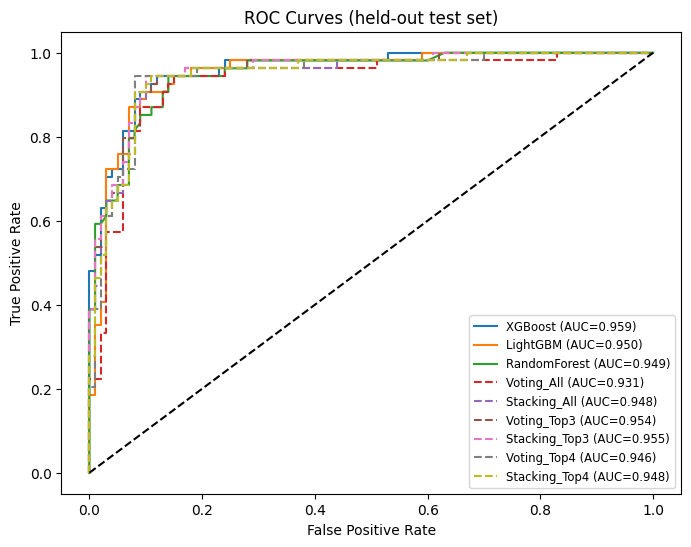


Held-out test set metrics:
LogisticRegression -> Acc: 73.4%, F1: 66.1%, Recall: 74.1%, ROC_AUC: 82.8%
RandomForest -> Acc: 88.3%, F1: 83.6%, Recall: 85.2%, ROC_AUC: 94.9%
SVC -> Acc: 83.1%, F1: 77.6%, Recall: 83.3%, ROC_AUC: 88.3%
KNN -> Acc: 75.3%, F1: 69.4%, Recall: 79.6%, ROC_AUC: 84.5%
MLP -> Acc: 84.4%, F1: 78.2%, Recall: 79.6%, ROC_AUC: 88.2%
XGBoost -> Acc: 90.9%, F1: 87.3%, Recall: 88.9%, ROC_AUC: 95.9%
LightGBM -> Acc: 89.6%, F1: 85.5%, Recall: 87.0%, ROC_AUC: 95.0%
Voting_All -> Acc: 87.7%, F1: 83.2%, Recall: 87.0%, ROC_AUC: 93.1%
Stacking_All -> Acc: 90.3%, F1: 86.2%, Recall: 87.0%, ROC_AUC: 94.8%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

Voting_Top3 -> Acc: 90.3%, F1: 86.2%, Recall: 87.0%, ROC_AUC: 95.4%
Stacking_Top3 -> Acc: 90.3%, F1: 86.2%, Recall: 87.0%, ROC_AUC: 95.5%
Voting_Top4 -> Acc: 90.3%, F1: 86.2%, Recall: 87.0%, ROC_AUC: 94.6%
Stacking_Top4 -> Acc: 90.3%, F1: 86.2%, Recall: 87.0%, ROC_AUC: 94.8%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [12]:
# Train ensembles on X_train and plot ROC curves on held-out X_test for visualization
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score, recall_score

# Fit individual models on X_train
fitted = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    fitted[name] = pipe

# Fit ensembles
clf_vote_all.fit(X_train, y_train)
clf_stack_all.fit(X_train, y_train)
clf_vote_top3.fit(X_train, y_train)
clf_stack_top3.fit(X_train, y_train)
clf_vote_top4.fit(X_train, y_train)
clf_stack_top4.fit(X_train, y_train)

#dictionary of all base models and ensembles models
allModels = {
    **fitted,
    "Voting_All": clf_vote_all,
    "Stacking_All": clf_stack_all,
    "Voting_Top3": clf_vote_top3,
    "Stacking_Top3": clf_stack_top3,
    "Voting_Top4": clf_vote_top4,
    "Stacking_Top4": clf_stack_top4
}

plt.figure(figsize=(8,6))
# Plot top 3 individual models by CV ranking
for name in ranked.index[:3]:
    prob = fitted[name].predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr, label=f"{name} (AUC={roc_auc:.3f})")

# Plot ensembles
for name in ["Voting_All", "Stacking_All", "Voting_Top3", "Stacking_Top3", "Voting_Top4", "Stacking_Top4"]:
    est = allModels[name]
    try:
        prob = est.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, prob)
        roc_auc = auc(fpr,tpr)
        plt.plot(fpr,tpr, linestyle='--', label=f"{name} (AUC={roc_auc:.3f})")
    except Exception as e:
        print("Could not plot", name, e)

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (held-out test set)')
plt.legend(loc='lower right', fontsize='small')
plt.show()

# Print test-set metrics for all models
from sklearn.metrics import accuracy_score, f1_score
print("\nHeld-out test set metrics:")
for name, est in allModels.items():
    try:
        yprob = est.predict_proba(X_test)[:,1]
        ypred = est.predict(X_test)
        acc = accuracy_score(y_test, ypred) * 100
        f1 = f1_score(y_test, ypred) * 100
        rec = recall_score(y_test, ypred) * 100
        roc = roc_auc_score(y_test, yprob) * 100
        print(f"{name} -> Acc: {acc:.1f}%, F1: {f1:.1f}%, Recall: {rec:.1f}%, ROC_AUC: {roc:.1f}%")
    except Exception as e:
        print(name, "error:", e)


To run SHAP, install shap (pip install shap) and then uncomment and run the code below. SHAP can be slow on non-tree models.
Best model by CV ROC-AUC: XGBoost


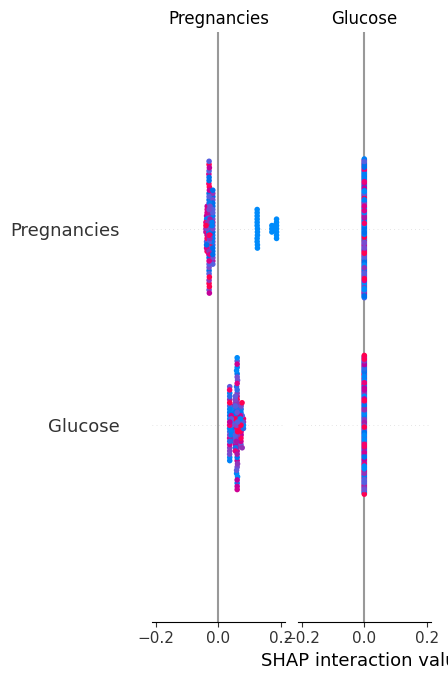

In [13]:
# OPTIONAL: SHAP explainability for the best model (uncomment install if needed)
print("To run SHAP, install shap (pip install shap) and then uncomment and run the code below. SHAP can be slow on non-tree models.")
# Example (commented):
import shap
best_name = cmp_df.sort_values('roc_auc_mean', ascending=False).index[0]
print('Best model by CV ROC-AUC:', best_name)
best_est = allModels[best_name]
# If pipeline, extract classifier (optional, but safe)
try:
    inner_clf = best_est.named_steps['clf']
except Exception:
    inner_clf = best_est

# Use predict_proba for SHAP (works for any estimator)
explainer = shap.Explainer(inner_clf.predict_proba, X_train)
shap_vals = explainer(X_test)

# Plot SHAP summary
shap.summary_plot(shap_vals, X_test)

In [14]:
import joblib

# List of model names to export (exclude LightGBM)
models_to_export = ["LogisticRegression", "RandomForest", "SVC", "KNN", "MLP", "XGBoost"]

for name in models_to_export:
    filename = f"model_{name}.pkl"
    joblib.dump(allModels[name], filename)
    print(f"Exported {name} to {filename}")

Exported LogisticRegression to model_LogisticRegression.pkl
Exported RandomForest to model_RandomForest.pkl
Exported SVC to model_SVC.pkl
Exported KNN to model_KNN.pkl
Exported MLP to model_MLP.pkl
Exported XGBoost to model_XGBoost.pkl


## The Imported Model are :


* LogisticRegression (model_LogisticRegression.pkl),
* RandomForest (model_RandomForest.pkl),
* SVC (model_SVC.pkl),
* KNN (model_KNN.pkl),
* MLP (model_MLP.pkl),
* XGBoost (model_XGBoost.pkl).

In [15]:
#OLD testing of the exported model

# import joblib
# import numpy as np
# loaded_model = joblib.load("trained_model.pkl")

# def predict_risk(data: dict) -> dict:
#     X = np.array([[data[0], data[1], data[2],
#                    data[3], data[4], data[5], data[6],
#                    (data[4] / data[6])]])

#     # Predict probability
#     proba = loaded_model.predict_proba(X)[:, 1]
#     risk = float(proba[0])

#     if risk <= 0.33:
#         label = "Low Risk"
#     elif risk <= 0.66:
#         label = "Medium Risk"
#     else:
#         label = "High Risk"

#     return {"raw_data": X, "outcome": label, "prediction_prob": round(risk * 100, 2)}


# #raw_input_data = [Pregnancies, Glucose, BloodPressure, Insulin, BMI, DiabeticFamily, Age]
# raw_input_data = (2,107,74,100,33.6,0,23)
# raw_input_data2 = (2,100,66,90,32.9,1,28)
# result = predict_risk(raw_input_data)
# result2 = predict_risk(raw_input_data2)
# print(result)
# print(result2)